# Mutational profiles from duplex sequencing samples

In [3]:
import pandas as pd
import json
from tqdm.notebook import tqdm

## Transform the counts to be relative to the mappable genome

In [24]:
%run ./scripts/functions_to_plot_profiles.py
%run ./scripts/functions_genome_contexts.py

keys = list(mut_key_gen())
mut_keys = [key[0]+key[1] for key in keys]

cols_dict = {'Subtype':'subtype','Context':'context','Sample':'sample','Mut Depth':'mut_depth',
             'Background Count':'BackgroundCount','Mean':'mean','Lower CI':'lower_ci',
            'Upper CI':'upper_ci'}

def make_channels (row):
    mut = row['subtype']
    context = row['context']
    channel = context[0]+'['+mut+']'+context[2]
    return channel

def make_dictionary (df1,context_genome_dict):     
    
    df1['channels'] = df1.apply(lambda row: make_channels(row),axis=1)
    df1['alt'] = df1['subtype'].str.split('>',expand=True)[1]
    df1['channels2'] = df1['context'] + df1['alt'] 
        
    #Transform decimal values (probabilities) as counts, with the proportion of triplet occurences in the genome
    df1['counts'] = df1.apply(lambda row: int(round(row['mean']*context_genome_dict[row['channels2']],0)),axis=1)
       
    dictionary = dict(zip(df1['channels'],df1['counts']))
    return dictionary

In [5]:
#prepare genome ccounts to mappable genome
mappable_genome_by_chunk_dict = json.load(open('./data/hg38_1000kb_bin.filtered.mappable_positions.autosomes.trinuc_per_bin.json','rb'))
contexts = mappable_genome_by_chunk_dict['chr1:3000000-4000000'].keys()
all_contexts_dict = { context:0 for context in contexts}

for chunk in tqdm(mappable_genome_by_chunk_dict.keys()):
    contexts_dict = mappable_genome_by_chunk_dict[chunk]
    for context in contexts:
        all_contexts_dict[context] = contexts_dict[context] + all_contexts_dict[context]
        
map_genome_contexts_dict = {}
for key in keys:
    context = key[0]
    mut = key[1]
    map_genome_contexts_dict[context+mut] = all_contexts_dict[context]
map_genome_contexts_dict

{'ACAA': 83603206,
 'ACCA': 46367544,
 'ACGA': 9335552,
 'ACTA': 67155246,
 'CCAA': 73859423,
 'CCCA': 52121678,
 'CCGA': 9622701,
 'CCTA': 71755035,
 'GCAA': 58743061,
 'GCCA': 46601530,
 'GCGA': 8245427,
 'GCTA': 56910121,
 'TCAA': 81205501,
 'TCCA': 62456262,
 'TCGA': 8043982,
 'TCTA': 92070619,
 'ACAG': 83603206,
 'ACCG': 46367544,
 'ACGG': 9335552,
 'ACTG': 67155246,
 'CCAG': 73859423,
 'CCCG': 52121678,
 'CCGG': 9622701,
 'CCTG': 71755035,
 'GCAG': 58743061,
 'GCCG': 46601530,
 'GCGG': 8245427,
 'GCTG': 56910121,
 'TCAG': 81205501,
 'TCCG': 62456262,
 'TCGG': 8043982,
 'TCTG': 92070619,
 'ACAT': 83603206,
 'ACCT': 46367544,
 'ACGT': 9335552,
 'ACTT': 67155246,
 'CCAT': 73859423,
 'CCCT': 52121678,
 'CCGT': 9622701,
 'CCTT': 71755035,
 'GCAT': 58743061,
 'GCCT': 46601530,
 'GCGT': 8245427,
 'GCTT': 56910121,
 'TCAT': 81205501,
 'TCCT': 62456262,
 'TCGT': 8043982,
 'TCTT': 92070619,
 'ATAA': 88390892,
 'ATCA': 54998890,
 'ATGA': 76404531,
 'ATTA': 106335106,
 'CTAA': 53988655,
 'CT

In [26]:
from pandas.api.types import CategoricalDtype
def create_snv_class(df):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    x = df['context']

    if x[1] in pyr:
        out = '{}{}{}{}'.format(x[0], x[1], x[2], df['alt'])
    else:
        out = '{}{}{}{}'.format(rev[x[2]], rev[x[1]], rev[x[0]], rev[df['alt']])

    return out

def context_pyr(x):
    pyr = ['C', 'T']
    rev = {'A': 'T', 'T': 'A', 'G': 'C', 'C': 'G', 'N': 'N'}

    if x[1] in pyr:
        return x
    else:
        return rev[x[2]]+rev[x[1]]+rev[x[0]]
    
def prepare_count_table(path):
    df = pd.read_csv(path,sep='\t')
    df['vaf'] = df['alt_depth'] / df['depth']
    df = df.rename(columns={'context':'context2'})
    df['context'] = df['context2'].apply(lambda x: context_pyr (x)) #trasnform all triplets into pyr perspective  
    
    path2 = path.replace('.mut','.genome.mut')
    df2 = pd.read_csv(path2,sep='\t')
    df2 = df2.rename(columns={'context':'context2'})
    df2['context'] = df2['context2'].apply(lambda x: context_pyr (x))  #trasnform all triplets into pyr perspective  
    df2 = df2[['context','depth']].groupby('context',as_index=False).sum() #sum all the times a triplet has been observed
    depth_dict = dict(zip(df2['context'],df2['depth']))

    df = df[(df['vaf']<0.35)&(df['variation_type']=='snv')] #filter by vaf<0.35 and snv
    df['channels'] = df.apply(create_snv_class, axis=1)

    cat_type = CategoricalDtype(categories=mut_keys, ordered=True)
    df['channels'] = df['channels'].astype(cat_type)
    df1 = df[['channels','subtype']].groupby(['channels'],as_index=False).count() #count mutations (not sum) to know number of unique muts
    df1 = df1.rename(columns={'subtype':'mut_count'})
    df1['context'] = df1['channels'].apply(lambda x: x[:-1])
    df1['subtype'] = df1['channels'].apply(lambda x: x[1]+'>'+x[3])
    df1['BackgroundCount'] = df1['context'].map(depth_dict)
    df1['mean'] = df1['mut_count'] / df1['BackgroundCount']
    return df1

def plot_signature_format (df1,title,dictionary=None):
    if dictionary == None:
        dictionary = make_dictionary(df1,map_genome_contexts_dict)
    dict_counts = change_dct_format(dictionary)
    fig, ax = plt.subplots()
    plot_signature(dict_counts, title=title ,fig=fig,ax=ax,figsize=(15,3),pad=50,labels=[])
    plt.ylabel('Percentage of\nSingle Base Substitutions',size=12)
    ax.spines['left'].set_color('lightgrey')        
    ax.spines['top'].set_color('lightgrey')  
    ax.spines['bottom'].set_color('lightgrey')        
    ax.spines['right'].set_color('lightgrey') 
    ax.grid(False)
    return ax

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (15) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


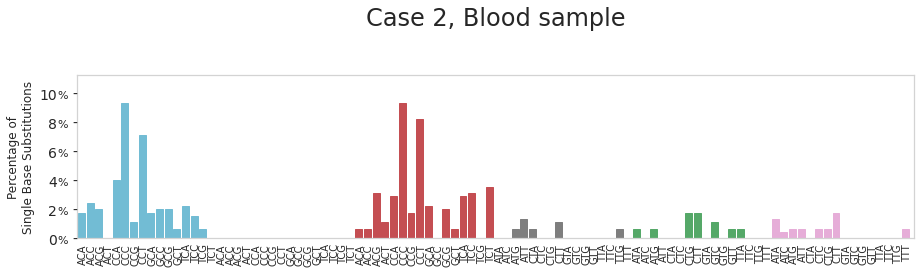

In [27]:
path = './output_dnanexus/'
sample = 'AU2198.1'
file = sample + '.consensus.variant-calls.mut'
df1 = prepare_count_table(path+file)
title = 'Case 2, Blood sample'
ax = plot_signature_format(df1,title)

ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,11,2))
for pos in range(0,12,2):
    plt.text(x=-2.8,y=pos-0.3,s='%',size=11)
for pos in range(0,12,2):
    plt.text(x=-1,y=pos-0.3,s='-',size=14)


plt.savefig('./figures_paper/case2_blood_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

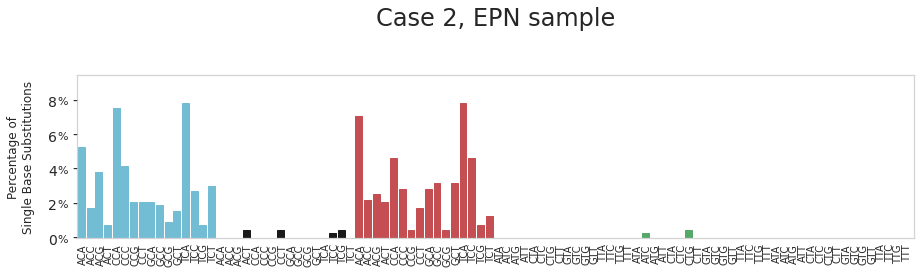

In [13]:
path = './output_dnanexus/'
sample = 'AU2199.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 2, EPN sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
for pos in range(0,9,2):
    plt.text(x=-2.8,y=pos-0.2,s='%',size=11)
for pos in range(0,9,2):
    plt.text(x=-1,y=pos-0.2,s='-',size=14)
plt.savefig('./figures_paper/case2_epn_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

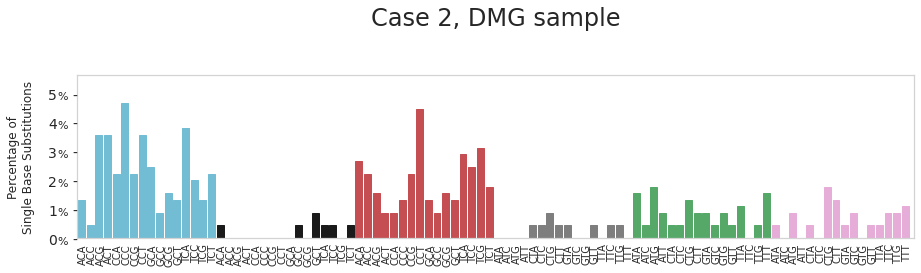

In [14]:
path = './output_dnanexus/'
sample = 'AU2200.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 2, DMG sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,6,1))
for pos in range(0,6,1):
    plt.text(x=-2.8,y=pos-0.2,s='%',size=11)
for pos in range(0,6,1):
    plt.text(x=-1,y=pos-0.2,s='-',size=14)
plt.savefig('./figures_paper/case2_dmg_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


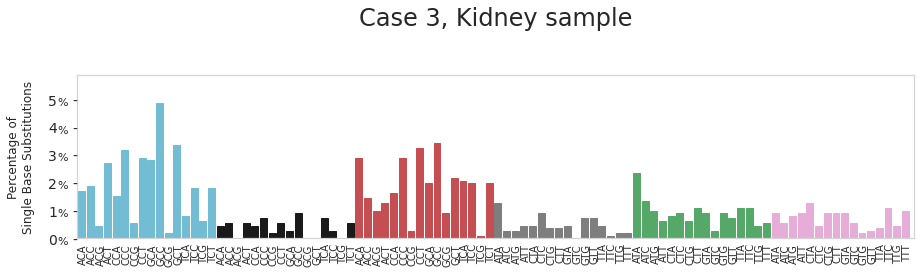

In [15]:
path = './output_dnanexus/'
sample = 'AZ4609.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 3, Kidney sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,6,1))
for pos in range(0,6,1):
    plt.text(x=-2.8,y=pos-0.2,s='%',size=11)
for pos in range(0,6,1):
    plt.text(x=-1,y=pos-0.2,s='-',size=14)
plt.savefig('./figures_paper/case3_kidney_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


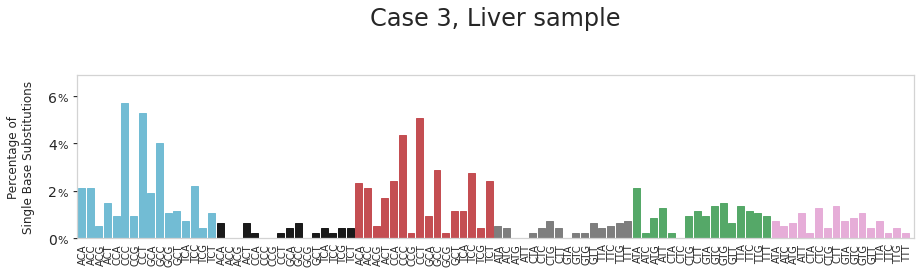

In [16]:
path = './output_dnanexus/'
sample = 'AZ4610.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 3, Liver sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
for pos in range(0,7,2):
    plt.text(x=-2.8,y=pos-0.2,s='%',size=11)
for pos in range(0,7,2):
    plt.text(x=-1,y=pos-0.2,s='-',size=14)
plt.savefig('./figures_paper/case3_liver_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


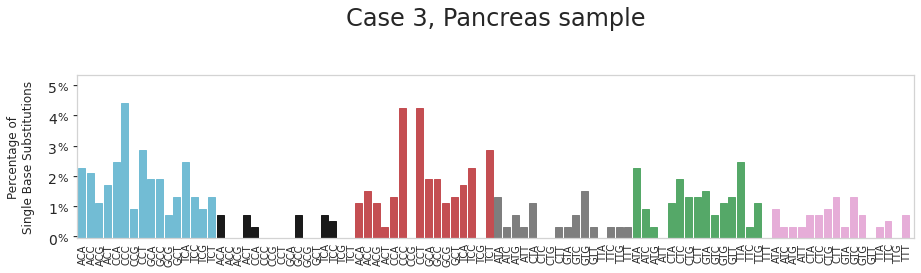

In [17]:
path = './output_dnanexus/'
sample = 'AZ4611.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 3, Pancreas sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,6,1))
for pos in range(0,6,1):
    plt.text(x=-2.8,y=pos-0.1,s='%',size=11)
for pos in range(0,6,1):
    plt.text(x=-1,y=pos-0.1,s='-',size=14)
plt.savefig('./figures_paper/case3_pancreas_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


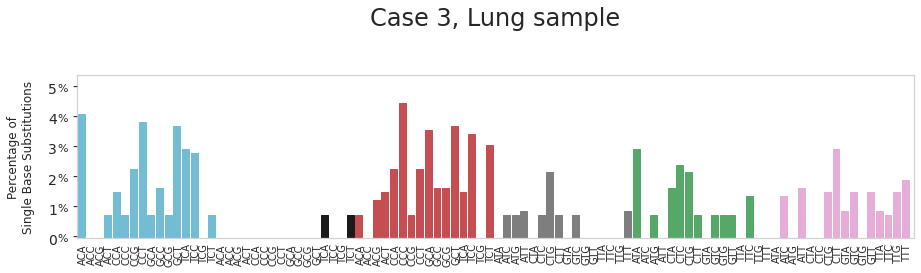

In [18]:
path = './output_dnanexus/'
sample = 'AZ4612.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 3, Lung sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,6,1))
for pos in range(0,6,1):
    plt.text(x=-2.8,y=pos-0.1,s='%',size=11)
for pos in range(0,6,1):
    plt.text(x=-1,y=pos-0.1,s='-',size=14)
plt.savefig('./figures_paper/case3_lung_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


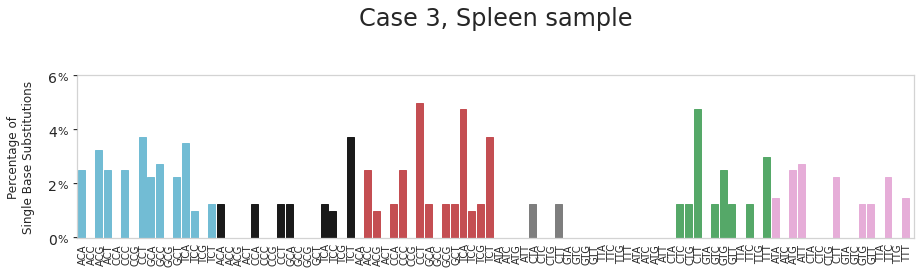

In [19]:
path = './output_dnanexus/'
sample = 'AZ4613.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 3, Spleen sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
for pos in range(0,7,2):
    plt.text(x=-2.8,y=pos-0.15,s='%',size=11)
for pos in range(0,7,2):
    plt.text(x=-1,y=pos-0.15,s='-',size=14)
plt.savefig('./figures_paper/case3_spleen_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (26,32,37) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


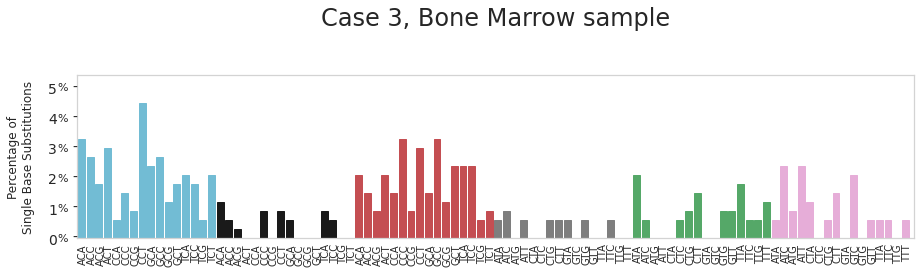

In [20]:
path = './output_dnanexus/'
sample = 'AZ4614.1'
file = sample + '.consensus.variant-calls.mut'
title = 'Case 3, Bone Marrow sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,6,1))
for pos in range(0,6,1):
    plt.text(x=-2.8,y=pos-0.1,s='%',size=11)
for pos in range(0,6,1):
    plt.text(x=-1,y=pos-0.1,s='-',size=14)
plt.savefig('./figures_paper/case3_bonemarrow_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

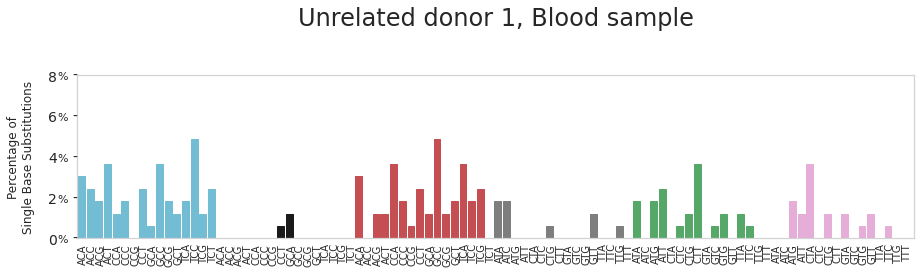

In [44]:
path = './output_dnanexus/'
sample = 'AZ6342.1'
file = 'CHp_39_T0.1.consensus.variant-calls.mut'
title = 'Unrelated donor 1, Blood sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,10,2))
for pos in range(0,10,2):
    plt.text(x=-2.8,y=pos-0.2,s='%',size=11)
for pos in range(0,10,2):
    plt.text(x=-1,y=pos-0.2,s='-',size=14)
plt.savefig('./figures_paper/unrelated1_blood_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

/home/msanchezg/miniconda3/envs/process_vc/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2818: DtypeWarning: Columns (32) have mixed types.Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


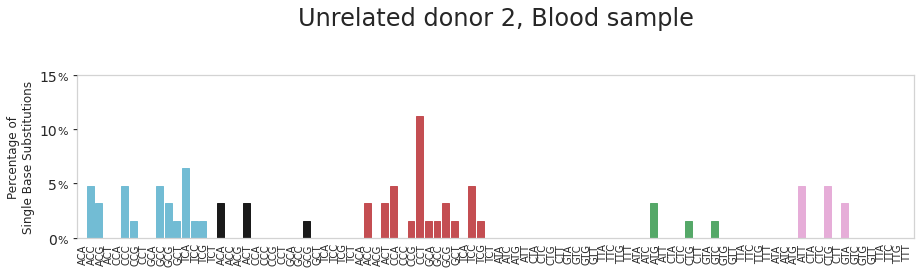

In [45]:
path = './output_dnanexus/'
sample = 'AZ6371.1'
file = 'CHp_38_T0.1.consensus.variant-calls.mut'
title = 'Unrelated donor 2, Blood sample'
df1 = prepare_count_table(path+file)
ax = plot_signature_format(df1,title)
ax.yaxis.set_label_coords(-.05, .5)
plt.yticks(range(0,20,5))
for pos in range(0,20,5):
    plt.text(x=-2.8,y=pos-0.4,s='%',size=11)
for pos in range(0,20,5):
    plt.text(x=-1,y=pos-0.4,s='-',size=14)
plt.savefig('./figures_paper/unrelated2_blood_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')

plt.show()

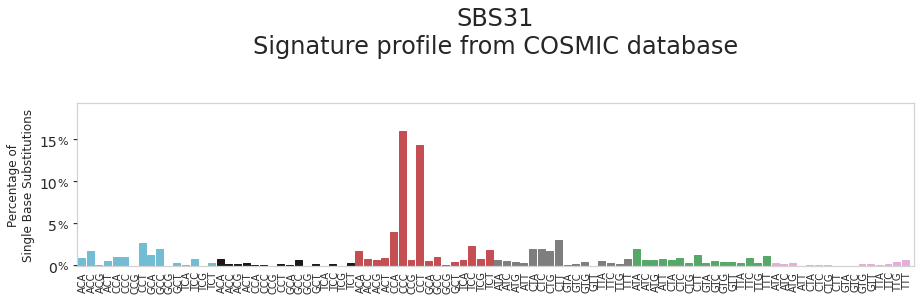

In [23]:
file = '../../wgs_analysis/tumor_vs_blood/signature_analysis/data/COSMIC_v3.3.1_SBS_GRCh38.txt'

df1 = pd.read_csv(file,sep='\t')
title = 'SBS31\nSignature profile from COSMIC database'
dictionary = dict(zip(df1['Type'],df1['SBS31']))
ax = plot_signature_format(df1,title,dictionary=dictionary)
ax.yaxis.set_label_coords(-.05, .5)
for pos in range(0,16,5):
    plt.text(x=-2.8,y=pos-0.4,s='%',size=11)
for pos in range(0,16,5):
    plt.text(x=-1,y=pos-0.4,s='-',size=14)
plt.savefig('./figures_paper/SBS31_profile.png',dpi=300, format='png',transparent=True,bbox_inches='tight')
plt.show()